# Test on Real Data

## Import

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '../bandits/bandits/')
#from utils import score
sys.path.pop(0)
from RealData.EpsGreedy import epsilon_greedy_policy, run_epsilon_policy
from RealData.score import score
from RealData. import 
from RealData. import 
from RealData. import 
from RealData. import 
from RealData. import 
#from RealData. import 
import matplotlib.pyplot as plt
import argparse

## Definition of Base Learners

In [13]:
def epsilon_greedy_policy(df, arms, epsilon=0.15, slate_size=5, batch_size=50):
    '''
    df: dataset to apply the policy to
    epsilon: float. represents the % of timesteps where we explore random arms
    slate_size: int. the number of recommendations to make at each step.
    batch_size: int. the number of users to serve these recommendations to before updating the bandit's policy.
    '''
    # draw a 0 or 1 from a binomial distribution, with epsilon% likelihood of drawing a 1
    explore = np.random.binomial(1, min(1,epsilon))
    # if explore: shuffle movies to choose a random set of recommendations
    if explore == 1 or df.shape[0]==0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)
    # if exploit: sort movies by "like rate", recommend movies with the best performance so far
    else:
        scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['movieId'] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], 'movieId'].values
    return recs

In [14]:
def score(history, df, t, batch_size, recs):
    # https://arxiv.org/pdf/1003.5956.pdf
    # replay score. reward if rec matches logged data, ignore otherwise
    #actions = df.copy()[t:t+batch_size]
    actions = df[t:t+batch_size]
    actions = actions.loc[actions['movieId'].isin(recs)]
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = pd.concat([history,actions])
    action_liked = actions[['movieId', 'liked']]
    return history, action_liked

## Load data

In [15]:
n=5 
epsilon=.01 
epsilon2=.2
batch_size=10000 
min_review_count=1500
verbose = 'FALSE'
balanced_classes = False

In [21]:
def read_data_20m():
	print('reading movielens 20m data')
	ratings = pd.read_csv('/Users/augustincablant/Documents/GitHub/Advanced-ML/data/ml-25m/ratings.csv', engine='python')  # 'data/ml-25m/ratings.csv'
	movies = pd.read_csv('/Users/augustincablant/Documents/GitHub/Advanced-ML/data/ml-25m/movies.csv', engine='python')   # 'data/ml-25m/movies.csv'
	#links = pd.read_csv('data/ml-25m/links.csv', engine='python')
	#tags = pd.read_csv('data/ml-25m/tags.csv', engine='python')
	movies = movies.join(movies.genres.str.get_dummies().astype(bool))
	movies.drop('genres', inplace=True, axis=1)
	logs = ratings.join(movies, on='movieId', how='left', rsuffix='_movie')
	return logs

In [22]:
def preprocess_movie_data_20m(logs, min_number_of_reviews=20000, balanced_classes=False):
	print('preparing ratings log')
	# remove ratings of movies with < N ratings. too few ratings will cause the recsys to get stuck in offline evaluation
	# Get counts of ratings for each movie
	movie_counts = logs['movieId'].value_counts()

	# Filter to keep only movies with enough ratings
	movies_to_keep = movie_counts[movie_counts >= min_number_of_reviews].index

	# Filter the logs to include only those movies
	logs = logs[logs['movieId'].isin(movies_to_keep)]
	logs = logs.loc[logs['movieId'].isin(movies_to_keep)]
	if balanced_classes is True:
		logs = logs.groupby('movieId')
		logs = logs.apply(lambda x: x.sample(logs.size().min()).reset_index(drop=True))
	# shuffle rows to deibas order of user ids
	logs = logs.sample(frac=1)
	# create a 't' column to represent time steps for the bandit to simulate a live learning scenario
	logs['t'] = np.arange(len(logs))
	logs.index = logs['t']
	logs['liked'] = logs['rating'].apply(lambda x: 1 if x >= 4.5 else 0)
	return logs

In [23]:
def get_ratings_20m(min_number_of_reviews=20000, balanced_classes=False):
	logs = read_data_20m()
	logs = preprocess_movie_data_20m(logs, min_number_of_reviews=20000, balanced_classes=balanced_classes)
	return logs

In [24]:
df = get_ratings_20m(min_number_of_reviews=min_review_count, balanced_classes=balanced_classes)

reading movielens 20m data
preparing ratings log


In [25]:
df.head()

,userId,movieId,rating,timestamp,movieId_movie,title,(no genres listed),Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,t,liked
t,,,,,,,,,,,,,,,,,,,,,
0,23893,6377,3.0,1512864078,6500.0,"Satanic Rites of Dracula, The (1974)",False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
1,149903,500,3.5,1514970568,505.0,North (1994),False,False,False,False,...,False,False,False,False,False,False,False,False,1,0
2,130027,296,4.5,1068423632,300.0,Quiz Show (1994),False,False,False,False,...,False,False,False,False,False,False,False,False,2,1
3,101701,2959,4.5,1071517936,3052.0,Dogma (1999),False,False,True,False,...,False,False,False,False,False,False,False,False,3,1
4,158905,2762,2.0,1382224036,2854.0,Don't Look in the Basement! (1973),False,False,False,False,...,False,False,False,False,False,False,False,False,4,0


## Run Experiment

### Fixed $\varepsilon$

In [26]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

In [28]:
df.shape[0]

6589715

In [14]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), epsilon=epsilon, slate_size=n, batch_size=batch_size)
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards.extend(action_score)

In [18]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})

In [19]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards2 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history2.loc[history2.t<=t,], arms=df.movieId.unique(), epsilon=epsilon2, slate_size=n, batch_size=batch_size)
	history2, action_score = score(history2, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards2.extend(action_score)

[]

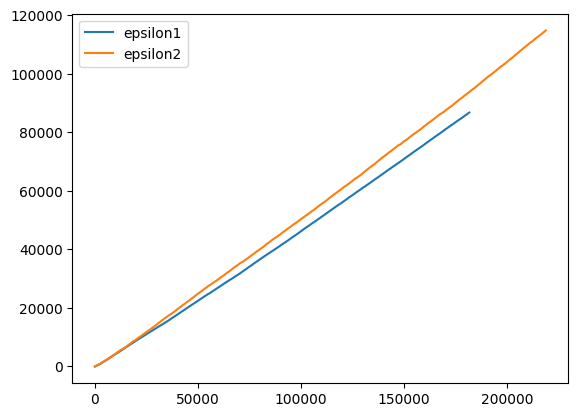

In [20]:
plt.plot(np.cumsum(rewards), label='epsilon1')
plt.plot(np.cumsum(rewards2), label='epsilon2')
plt.legend()
plt.plot()

### Varying $\varepsilon_t$

In [48]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})

Make use of eps-greedy algo with fixed $\epsilon$, but we give as input an updated $\epsilon$ at each $t$.

In [49]:
c = 1e5

In [50]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards3 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	if t == 0:
		epsilon3 = c
	else:
		epsilon3 = c/t
	if t % 10:
		print(epsilon3)
	recs = epsilon_greedy_policy(df=history3.loc[history3.t<=t,], arms=df.movieId.unique(), epsilon=epsilon3, slate_size=n, batch_size=batch_size)
	history3, action_score = score(history3, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards3.extend(action_score)

[]

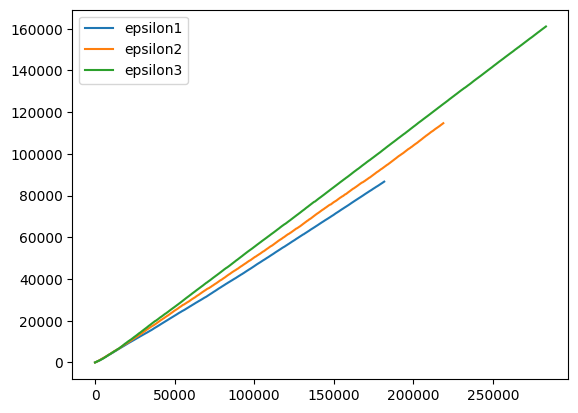

In [51]:
plt.plot(np.cumsum(rewards), label='epsilon1')
plt.plot(np.cumsum(rewards2), label='epsilon2')
plt.plot(np.cumsum(rewards3), label='epsilon3')
plt.legend()
plt.plot()

different end time since in the training loop we check if we can receive a feed back, not equal among all run

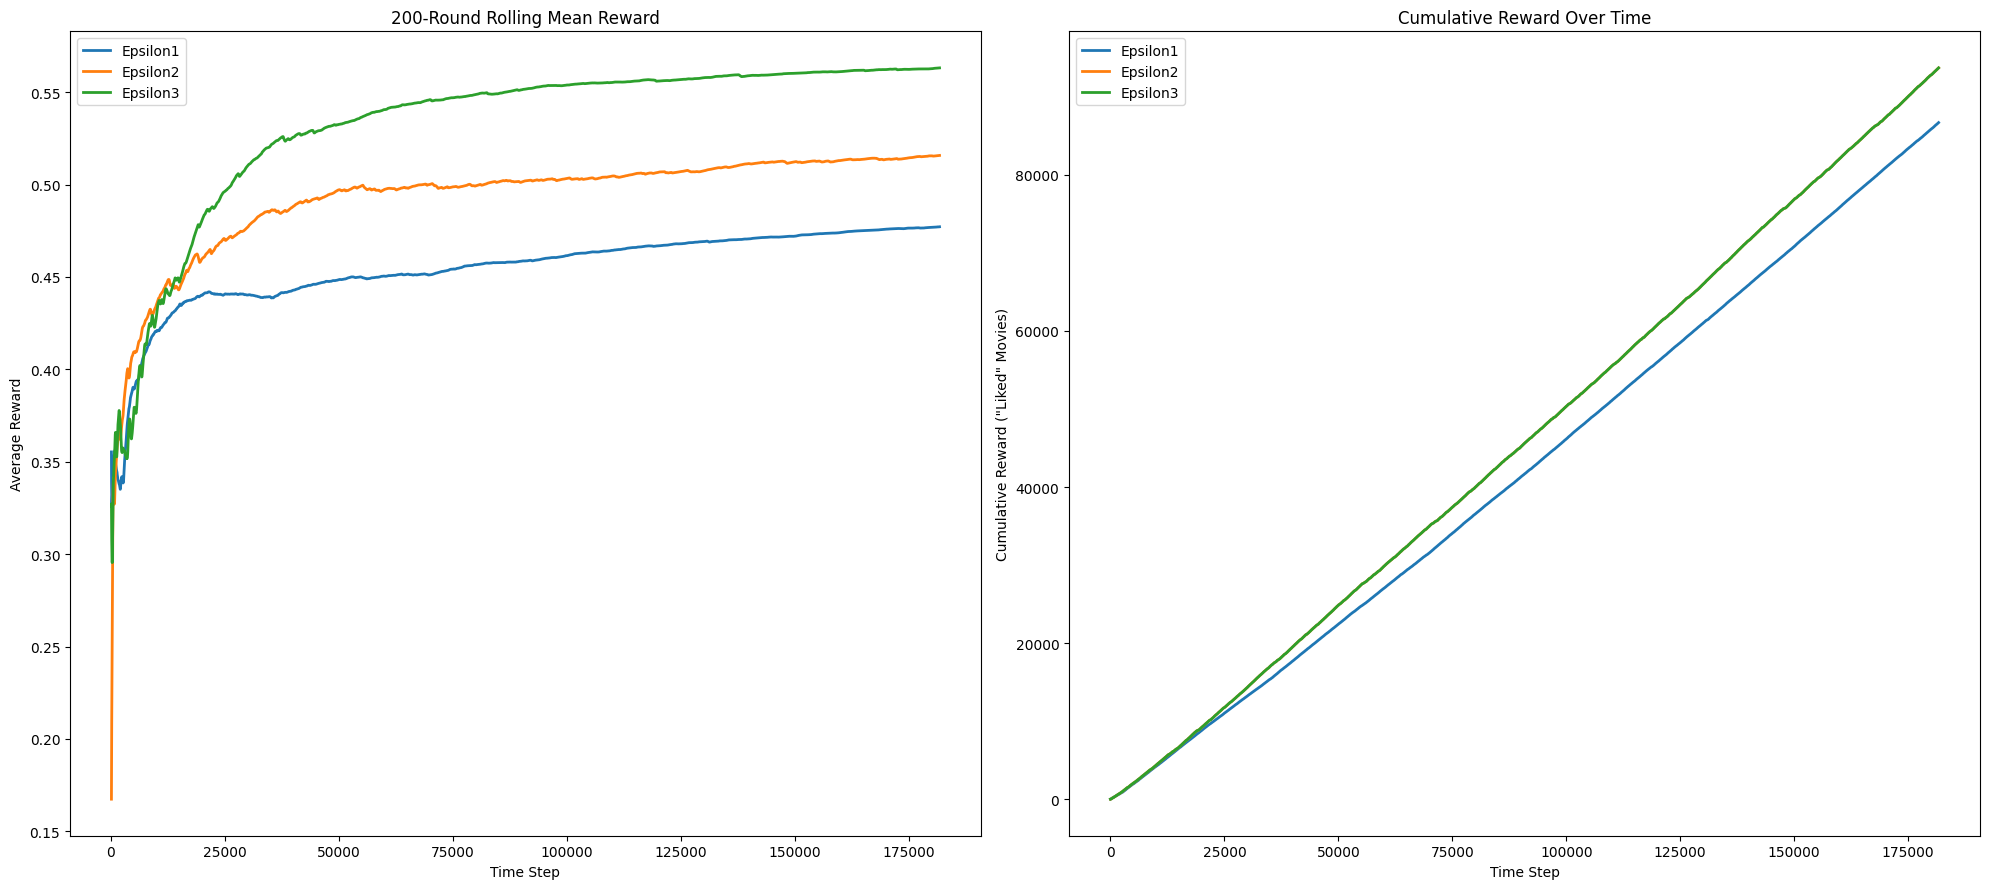

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

L = min(len(rewards), len(rewards2), len(rewards3))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='Epsilon1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='Epsilon2')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='Epsilon3')


axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))

axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='Epsilon1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='Epsilon2')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='Epsilon3')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()